# Setup

This notebook does layerwise evaluations of large language models using a variety of evaluation metrics.
Authors: Oscar Skean

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2LMHeadModel, GPT2Model, AutoModel
from utils.misc.metric_utils import (
    compute_per_forward_pass,
    compute_on_concatenated_passes,
    metric_name_to_function
)
from utils.misc.model_dataloader_utils import model_name_to_sizes, get_model_path, get_dataloader, get_augmentation_collated_dataloader

device = "cuda:1"
DISABLE_TQDM = True

# Layerwise Evaluations

In [2]:
class ModelSpecifications:
    def __init__(self, model_family, model_size, revision):
        self.model_family = model_family
        self.model_size = model_size
        self.revision = revision

        self.do_checks()
    
    def do_checks(self):
        if self.revision != "main":
            # currently only supporting 14m and 410m Pythia models for checkpoints
            assert self.model_family == "Pythia"
            assert self.model_size in ["14m", "410m"]

        assert self.model_family in model_name_to_sizes.keys()
        assert self.model_size in model_name_to_sizes[self.model_family]

class EvaluationMetricSpecifications:
    def __init__(
        self, 
        evaluation_metric, 
        num_samples = 1000, 
        alpha = 1, 
        normalizations = ['maxEntropy', 'raw', 'logN', 'logNlogD', 'logD'],
        curvature_k = 1
    ):
        self.evaluation_metric = evaluation_metric
        self.num_samples = num_samples

        
        if self.evaluation_metric == 'sentence-entropy':
            self.granularity = 'sentence'
            self.evaluation_metric = 'entropy'
        elif self.evaluation_metric == 'dataset-entropy':
            self.granularity = 'dataset'
            self.evaluation_metric = 'entropy'
        else:
            self.granularity = None

        # for matrix-based metrics (LIDAR, DIME, entropy)
        self.normalizations = normalizations
        self.alpha = alpha

        # for curvature
        self.curvature_k = curvature_k
        
        self.do_checks()

    def do_checks(self):
        assert self.evaluation_metric in metric_name_to_function.keys()
        assert self.granularity in ['sentence', 'dataset', None]

        assert self.alpha > 0
        assert self.num_samples > 0
        assert self.curvature_k > 0 and isinstance(self.curvature_k, int)

In [3]:
def save_results(results, model_specs: ModelSpecifications, evaluation_metric_specs: EvaluationMetricSpecifications, dataloader_kwargs):
    model_family = model_specs.model_family
    model_size = model_specs.model_size
    revision = model_specs.revision
    evaluation_metric = evaluation_metric_specs.evaluation_metric
    granularity = evaluation_metric_specs.granularity
    dataset = dataloader_kwargs['dataset_name']

    if evaluation_metric == 'entropy':
        evaluation_metric = f"{evaluation_metric}_{granularity}"

    save_dir = f"results/{model_family}/{model_size}/{revision}/metrics/{dataset}/"
    os.makedirs(save_dir, exist_ok=True)
    with open(f"{save_dir}/{evaluation_metric}.pkl", "wb") as f:
        pickle.dump(results, f)
        
def load_results(model_specs: ModelSpecifications, evaluation_metric_specs: EvaluationMetricSpecifications, dataloader_kwargs):
    model_family = model_specs.model_family
    model_size = model_specs.model_size
    revision = model_specs.revision
    evaluation_metric = evaluation_metric_specs.evaluation_metric
    granularity = evaluation_metric_specs.granularity
    dataset = dataloader_kwargs['dataset_name']

    if evaluation_metric == 'entropy':
        evaluation_metric = f"{evaluation_metric}_{granularity}"

    load_dir = f"results/{model_family}/{model_size}/{revision}/metrics/{dataset}/"
    file_path = f"{load_dir}/{evaluation_metric}.pkl"

    try:
        with open(file_path, "rb") as f:
            results = pickle.load(f)
        return results
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

def load_results_for_model_and_revisions(model_family, model_size, revisions, evaluation_metrics):
    results = {}
    for revision in revisions:
        model_specs = ModelSpecifications(model_family, model_size, revision)
        for evaluation_metric in evaluation_metrics:
            evaluation_metric_specs = EvaluationMetricSpecifications(evaluation_metric)
            dataloader_kwargs = {'dataset_name': 'wikitext'}
            results[(revision, evaluation_metric)] = load_results(model_specs, evaluation_metric_specs, dataloader_kwargs)
    return results

In [4]:
def calculate_and_save_layerwise_metrics(
    model_specs: ModelSpecifications,
    evaluation_metric_specs: EvaluationMetricSpecifications,
):
    dataloader_kwargs = {
        "dataset_name": "wikitext",
        "split": "train",
        "num_samples": 10000,
        "max_sample_length": 512 if model_specs.model_family == "bert" else 2048,
    }

    model_path = get_model_path(model_specs.model_family, model_specs.model_size)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path, 
                                      output_hidden_states=True, 
                                      torch_dtype=torch.bfloat16,
                                      revision=model_specs.revision).to(device)
    


    if evaluation_metric_specs.evaluation_metric == 'entropy':
        dataloader = get_dataloader(tokenizer, **dataloader_kwargs)
        compute_func_kwargs = {
            'alpha': evaluation_metric_specs.alpha,
            'normalizations': evaluation_metric_specs.normalizations
        }
        forward_pass_func = compute_per_forward_pass if evaluation_metric_specs.granularity == 'sentence' else compute_on_concatenated_passes
  

    elif evaluation_metric_specs.evaluation_metric == 'curvature':
        dataloader = get_dataloader(tokenizer, **dataloader_kwargs)
        compute_func_kwargs = {
            'k': evaluation_metric_specs.curvature_k
        }
        forward_pass_func = compute_per_forward_pass

    elif evaluation_metric_specs.evaluation_metric == 'lidar':
        dataloader_kwargs['num_augmentations_per_sample'] = 16
        dataloader = get_augmentation_collated_dataloader(tokenizer, **dataloader_kwargs)
        compute_func_kwargs = {
            'alpha': evaluation_metric_specs.alpha,
            'normalizations': evaluation_metric_specs.normalizations,
        }
        forward_pass_func = compute_on_concatenated_passes

    elif evaluation_metric_specs.evaluation_metric == 'dime':
        dataloader_kwargs['num_augmentations_per_sample'] = 2
        dataloader = get_augmentation_collated_dataloader(tokenizer, **dataloader_kwargs)
        compute_func_kwargs = {
            'alpha': evaluation_metric_specs.alpha,
            'normalizations': evaluation_metric_specs.normalizations,
        }
        forward_pass_func = compute_on_concatenated_passes

    elif evaluation_metric_specs.evaluation_metric == 'infonce':
        dataloader_kwargs['num_augmentations_per_sample'] = 2
        dataloader = get_augmentation_collated_dataloader(tokenizer, **dataloader_kwargs)
        compute_func_kwargs = {
            'temperature': 0.1,
        }
        forward_pass_func = compute_on_concatenated_passes

    compute_func = metric_name_to_function[evaluation_metric_specs.evaluation_metric]
    results = forward_pass_func(model, dataloader, compute_func, **compute_func_kwargs)
    save_results(results, model_specs, evaluation_metric_specs, dataloader_kwargs)


In [5]:
from itertools import product

def is_already_computed(model_specs, evaluation_metric_specs):
    try:
        results = load_results(model_specs, evaluation_metric_specs, {'dataset_name': 'wikitext'})
        return results is not None
    except:
        return False
    

model_names = ['Pythia', 'bert', 'mamba', ]
evaluation_metrics = ['infonce', 'dime', 'lidar', 'sentence-entropy', 'dataset-entropy', 'curvature']

#pythia_revision_steps = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 128000]
#revisions = ['main'] + [f"step{step}" for step in pythia_revision_steps]
revisions = ['main']
num_samples = 1000

for model_name, revision, evaluation_metric in product(model_names, revisions, evaluation_metrics):
    for model_size in model_name_to_sizes[model_name]:
        try:
        
            model_spec = ModelSpecifications(model_family=model_name, model_size=model_size, revision=revision)
            eval_spec = EvaluationMetricSpecifications(
                evaluation_metric=evaluation_metric,
                alpha=2,
                num_samples=num_samples
            )
            
            if not is_already_computed(model_spec, eval_spec):
                print(f"Computing: {model_name}, {evaluation_metric}, {revision}, {model_size}")
                calculate_and_save_layerwise_metrics(model_spec, eval_spec)
            else:
                print(f"Already computed: {model_name}, {evaluation_metric}, {revision}, {model_size}")
            
        except Exception as e:
            print(f"\tError for {model_name}, {evaluation_metric}, {revision}: {str(e)}")

Already computed: Pythia, infonce, main, 14m
Already computed: Pythia, infonce, main, 70m
Already computed: Pythia, infonce, main, 160m
Already computed: Pythia, infonce, main, 410m
Already computed: Pythia, infonce, main, 1b
Already computed: Pythia, infonce, main, 1.4b
Already computed: Pythia, infonce, main, 2.8b
Already computed: Pythia, dime, main, 14m
Already computed: Pythia, dime, main, 70m
Already computed: Pythia, dime, main, 160m
Already computed: Pythia, dime, main, 410m
Already computed: Pythia, dime, main, 1b
Already computed: Pythia, dime, main, 1.4b
Already computed: Pythia, dime, main, 2.8b
Already computed: Pythia, lidar, main, 14m
Already computed: Pythia, lidar, main, 70m
Already computed: Pythia, lidar, main, 160m
Already computed: Pythia, lidar, main, 410m
Already computed: Pythia, lidar, main, 1b
Already computed: Pythia, lidar, main, 1.4b
Already computed: Pythia, lidar, main, 2.8b
Already computed: Pythia, sentence-entropy, main, 14m
Already computed: Pythia, s

/home/AD/ofsk222/miniconda3/envs/information_plane/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

100%|█████████▉| 999/1000 [16:17<00:00,  1.02it/s]

	Error for mamba, lidar, main: CUDA out of memory. Tried to allocate 9.92 GiB. GPU  has a total capacity of 23.68 GiB of which 4.83 GiB is free. Including non-PyTorch memory, this process has 18.83 GiB memory in use. Of the allocated memory 15.49 GiB is allocated by PyTorch, and 3.09 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Already computed: mamba, sentence-entropy, main, 130m
Already computed: mamba, sentence-entropy, main, 370m
Already computed: mamba, sentence-entropy, main, 790m
Already computed: mamba, sentence-entropy, main, 1.4b
Already computed: mamba, sentence-entropy, main, 2.8b
Already computed: mamba, dataset-entropy, main, 130m
Already computed: mamba, dataset-entropy, main, 370m
Already computed: mamba, dataset-entropy, main, 790

## Data Augmentation

In [6]:
from utils import text_augmentation

input_text = ["The quick brown fox jumps over the lazy dog."]

augmented_text = text_augmentation(input_text, num_augmentations_per_sample=10)
print(f"Original text: {input_text}")
for i, t in enumerate(augmented_text[0].split(',')):
    print(f"Augmented text {i}: {t}")

ImportError: cannot import name 'text_augmentation' from 'utils' (unknown location)

# Plotting

In [ ]:
import matplotlib.pyplot as plt
import pickle

def load_results_layerwise_entropies(model_name, experiment_name, granularity, normalization):
    with open(f"entropy_results/entropy={experiment_name}_model={model_name}_granularity={granularity}_normalization={normalization}.pkl", "rb") as f:
        layerwise_entropies_per_model = pickle.load(f)
    return layerwise_entropies_per_model

SHOULD_USE_DEPTH_PERCENTAGE =True 


models = ["EleutherAI", "mamba", "bert"] 
experiments = ["curvature", "entropy", "entropy","lidar", "dime", 'infonce']

A = len(models)
B = len(experiments)
fig, axs = plt.subplots(A, B, figsize=(5 * B, 5 * A))

row_labels = ['Pythia', 'Mamba', 'BERT']
col_labels = ['Curvature', 'Von Neumann Entropy (Prompt)', 'Von Neumann Entropy (Dataset)', 'LIDAR', 'DiME']

# Iterate over models and experiments
for i, model_family in enumerate(models):
    for j, evaluation_metric in enumerate(experiments):
        # Load entropies for each model and experiment
        granularity = 'sentence' if 'entropy' in evaluation_metric and j==1 else 'dataset'
        granularity = 'sentence' if 'curvature' in evaluation_metric else granularity

        normalization = 'maxEntropy'
        normalization = 'raw' if 'curvature' in evaluation_metric else normalization

        try:
            layerwise_entropies = load_results_layerwise_entropies(model_family, evaluation_metric, granularity=granularity, normalization=normalization)
        except FileNotFoundError as e:
            print(e)
            layerwise_entropies=None

        # Access the corresponding subplot
        ax = axs[i, j] if A > 1 and B > 1 else axs[j] if A == 1 else axs[i]

        if layerwise_entropies is not None:
            # for pythia, only plot 1B and 1.4B models
            if model_family == "EleutherAI":
                layerwise_entropies = {k: v for k, v in layerwise_entropies.items() if k not in ['1.4b', '2.8b', '6.9b']}
            for model_size_idx, (model_variant, entropies) in enumerate(layerwise_entropies.items()):
                offset = 4
                color = plt.cm.BuGn( (model_size_idx+offset) / (len(layerwise_entropies) + offset) )

                if SHOULD_USE_DEPTH_PERCENTAGE:
                    depth_percentage = np.linspace(0, 100, len(entropies))
                    ax.plot(depth_percentage, entropies, marker='o', label=model_variant, color=color)
                else:
                    ax.plot(entropies, marker='o', label=model_variant, color=color)
        else:
            ax.text(0.5, 0.5, 'Missing data', ha='center', va='center', fontsize=12, color='red')

        if SHOULD_USE_DEPTH_PERCENTAGE:
            ax.set_xlabel('Depth Percentage')
        else:   
            ax.set_xlabel('Layer')
        ax.set_ylabel(f'{col_labels[j]}')
        if i==0:
            ax.set_title(f'{col_labels[j]}')
        
        if j == 0:
            ax.legend()
        ax.grid(True)
# Set row labels using ax.text
for i, row in enumerate(row_labels):
    y_position = (A-i-0.5)/A
    if i == len(models)-1:
        y_position += 0.02
    fig.text(-0.001, y_position, row, rotation=90, va='center', ha='right', fontsize='x-large')

# Adjust layout
plt.tight_layout()
plt.show()

# Plot Normalizations

In [ ]:
print(results)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def load_results_for_model_and_revisions(model_family, model_sizes, revisions, evaluation_metrics):
    results = {}
    for revision in revisions:
        for model_size in model_sizes:
            model_specs = ModelSpecifications(model_family, model_size, revision)
            for evaluation_metric in evaluation_metrics:
                evaluation_metric_specs = EvaluationMetricSpecifications(evaluation_metric)
            dataloader_kwargs = {'dataset_name': 'wikitext'}
            results[(revision, evaluation_metric, model_size)] = load_results(model_specs, evaluation_metric_specs, dataloader_kwargs)
    return results

model_family = "Pythia"
revisions = ['main']
evaluation_metric = "sentence-entropy"
model_sizes = model_name_to_sizes[model_family]

results = load_results_for_model_and_revisions(model_family, model_sizes, revisions, [evaluation_metric])
# Create a figure with subplots for each normalization
normalizations = list(next(iter(results.values())).keys())
fig, axs = plt.subplots(1, len(normalizations), figsize=(18, 6), squeeze=False)
axs = axs.flatten()  # Flatten axs to handle both single and multiple subplots
fig.suptitle(f'{evaluation_metric.capitalize()} for {model_family.capitalize()} Models', fontsize=16)

for i, normalization in enumerate(normalizations):
    for model_size_idx, model_size in enumerate(model_sizes):
        entropies = results[(revisions[0], evaluation_metric, model_size)][normalization]
        offset = 4
        color = plt.cm.BuGn((model_size_idx + offset) / (len(model_sizes) + offset))
        
        if True:
            depth_percentage = np.linspace(0, 100, len(entropies))
            axs[i].plot(depth_percentage, entropies, marker='o', label=f'{model_size}', color=color)
        else:
            axs[i].plot(entropies, marker='o', label=f'{model_size}', color=color)
    
    axs[i].set_title(f'Normalization: {normalization.capitalize()}')
    axs[i].set_xlabel('Depth Percentage')
    axs[i].set_ylabel(evaluation_metric.capitalize())
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# Plot Model Checkpoints

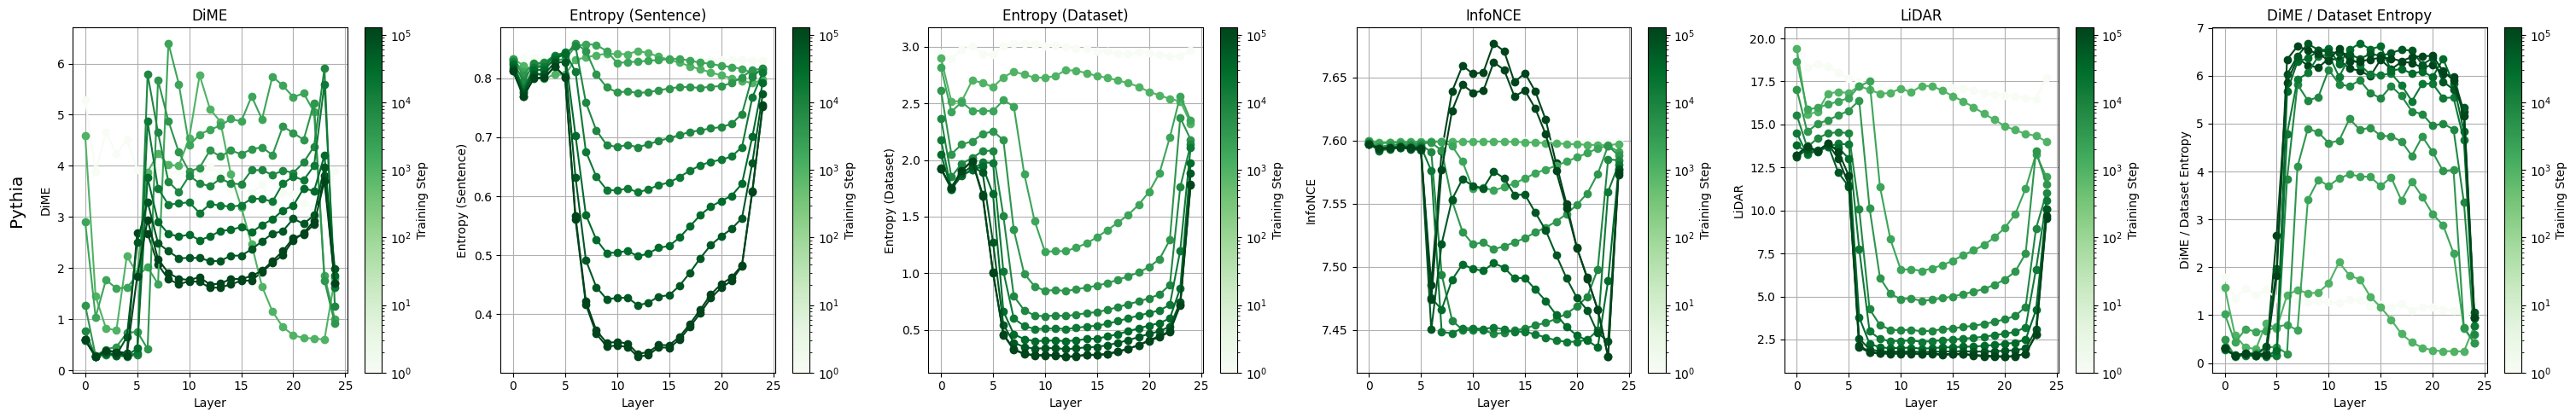

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

models = ["Pythia"]
metrics = ["dime", "sentence-entropy", "dataset-entropy", "infonce", "lidar"]
#pythia_revision_steps = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 128000]
pythia_revision_steps = [1, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 128000]
revisions = ['main'] + [f"step{step}" for step in pythia_revision_steps]

results = load_results_for_model_and_revisions("Pythia", "410m", revisions, metrics)

model_name_to_label = {
    "Pythia": "Pythia",
}
metric_name_to_label = {
    "dime": "DiME",
    "sentence-entropy": "Entropy (Sentence)",
    "dataset-entropy": "Entropy (Dataset)",
    "infonce": "InfoNCE",
    "lidar": "LiDAR"
}

metric_name_to_normalization = {
    "dime": "raw",
    "sentence-entropy": "maxEntropy",
    "dataset-entropy": "maxEntropy",
    "infonce": "raw",
    "lidar": "raw"
}

# Add a new metric for DiME normalized by dataset entropy
metrics.append("dime-normalized")
metric_name_to_label["dime-normalized"] = "DiME / Dataset Entropy"
metric_name_to_normalization["dime-normalized"] = "raw"
for revision in revisions:
    dime_results = results[(revision, "dime")]["raw"]
    dataset_entropy_results = results[(revision, "dataset-entropy")]["maxEntropy"]
    if len(dime_results) != len(dataset_entropy_results):
        raise ValueError(f"Length mismatch for revision {revision}: DiME ({len(dime_results)}) vs Dataset Entropy ({len(dataset_entropy_results)})")
    normalized_results = [dime / entropy if entropy != 0 else 0 for dime, entropy in zip(dime_results, dataset_entropy_results)]
    results[(revision, "dime-normalized")] = {"raw": normalized_results}


A = len(models)
B = len(metrics)
fig, axs = plt.subplots(A, B, figsize=(5 * B, 5 * A))
if B == 1:
    axs = [axs]



for i, model_family in enumerate(models):
    for j, evaluation_metric in enumerate(metrics):
        ax = axs[i, j] if A > 1 and B > 1 else axs[j] if A == 1 else axs[i]
        
        if results:
            cmap = plt.cm.Greens
            norm = colors.LogNorm(vmin=min(pythia_revision_steps), vmax=max(pythia_revision_steps))

            for revision in revisions:
                metric_results = results[(revision, evaluation_metric)]
                metric_results = metric_results[metric_name_to_normalization[evaluation_metric]]
                
                if revision == 'main':
                    step = 143000
                else:
                    step = int(revision.split('step')[1])
                color = cmap(norm(step))

                ax.plot(range(len(metric_results)), metric_results, marker='o', color=color, label=f'Step {step}')
        else:
            ax.text(0.5, 0.5, 'Missing data', ha='center', va='center', fontsize=12, color='red')

        ax.set_xlabel('Layer')
        ax.set_ylabel(metric_name_to_label[evaluation_metric])
        if i == 0:
            ax.set_title(metric_name_to_label[evaluation_metric])
        
        ax.grid(True)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Training Step')

# Set row labels
for i, model in enumerate(models):
    y_position = (A-i-0.5)/A
    if i == len(models)-1:
        y_position += 0.02
    fig.text(-0.001, y_position, model_name_to_label[model], rotation=90, va='center', ha='right', fontsize='x-large')

plt.tight_layout()
plt.show()

# Todo: for dime

NameError: name 'load_results_layerwise_entropies' is not defined

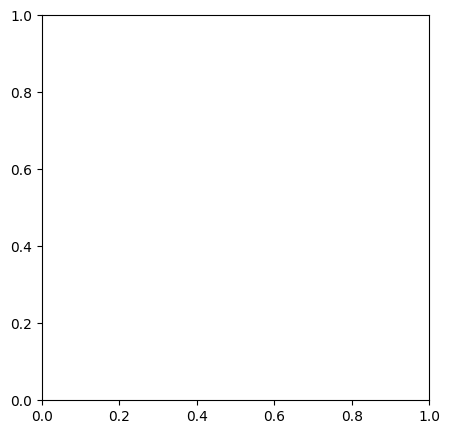

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

SHOULD_USE_DEPTH_PERCENTAGE = False

models = ["EleutherAI"]
experiments = ["dime"]

A = len(models)
B = len(experiments)
fig, axs = plt.subplots(A, B, figsize=(5 * B, 5 * A))
if A == 1:
    axs = [axs]


dime_results = load_results_layerwise_entropies("EleutherAI", "dime", granularity="sentence", normalization="raw")

row_labels = ['Pythia']
col_labels = ['DiME']

# Iterate over models and experiments
for i, model_family in enumerate(models):
    for j, evaluation_metric in enumerate(experiments):
        # Load entropies for each model and experiment
        granularity = 'dataset'

        normalization = 'raw'
        normalization = 'raw' if 'curvature' in evaluation_metric else normalization
        normalization = 'raw' if 'infonce' in evaluation_metric else normalization
        normalization = 'maxEntropy' if 'lidar' in evaluation_metric else normalization

        layerwise_entropies = load_results_layerwise_entropies(model_family, evaluation_metric, granularity=granularity, normalization=normalization, revisioned=True)

        # Access the corresponding subplot
        ax = axs[i, j] if A > 1 and B > 1 else axs[j] if A == 1 else axs[i]
        if layerwise_entropies is not None:
            for model_size_idx, (model_variant, entropies) in enumerate(layerwise_entropies.items()):
                step = int(model_variant.split('_step')[1])
                color = plt.cm.Greens((30000+step) / 150000)  # Normalize step to [0, 1]


                entropies /= (2*entropy_results)**1

                if SHOULD_USE_DEPTH_PERCENTAGE:
                    depth_percentage = np.linspace(0, 100, len(entropies))
                    ax.plot(depth_percentage, entropies, marker='o', color=color)
                else:
                    ax.plot(entropies, marker='o', color=color)
        else:
            ax.text(0.5, 0.5, 'Missing data', ha='center', va='center', fontsize=12, color='red')

        if SHOULD_USE_DEPTH_PERCENTAGE:
            ax.set_xlabel('Depth Percentage')
        else:   
            ax.set_xlabel('Layer')
        ax.set_ylabel(f'{col_labels[j]}')
        if i==0:
            ax.set_title(f'{col_labels[j]}')
        
        ax.grid(True)

        # Add colorbar as legend
        cmap = plt.cm.get_cmap('Greens').copy()
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=140000))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Training Step')

# Set row labels using ax.text
for i, row in enumerate(row_labels):
    y_position = (A-i-0.5)/A
    if i == len(models)-1:
        y_position += 0.02
    fig.text(-0.001, y_position, row, rotation=90, va='center', ha='right', fontsize='x-large')

# Adjust layout
plt.tight_layout()
plt.show()